In [ ]:
# ECGR 4105 HW5: Neural Networks
# Author: Lucas Therrien
# Student ID #801122089
# GitHub Link: https://github.com/lucastherrien/ECGR4105HW5

In [ ]:
##_________________________________________##
## Setup
##_________________________________________##

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nbconvert
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer 
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.svm import SVC, SVR
import seaborn as sns
from matplotlib.colors import ListedColormap
import torch.nn as nn
import torch
from torch import optim
#Suppress all warnings because they annoy me
import warnings
warnings.filterwarnings("ignore")

In [ ]:
##_________________________________________##
## Problem 1
##_________________________________________##

In [90]:
# model eq: w2 * t_u ** 2 + w1 * t_u + b
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_u = torch.tensor(t_u).unsqueeze(1)
t_un = 0.1*t_u
print(t_un)

tensor([[3.5700],
        [5.5900],
        [5.8200],
        [8.1900],
        [5.6300],
        [4.8900],
        [3.3900],
        [2.1800],
        [4.8400],
        [6.0400],
        [6.8400]])


In [47]:
def model_2nd_order(t_u, w1, w2, b):
    return w2 * t_u ** 2 + w1 * t_u + b

def model_1st_order(t_u, w1, b):
    return w1 * t_u + b

def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)  # <1>
    return dsq_diffs

def dmodel_dw2(t_u):
    return t_u**2

def dmodel_dw1(t_u):
    return t_u

def grad_fn_2nd_order(t_u, t_c, t_p):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw2 = dloss_dtp * dmodel_dw2(t_u)
    dloss_dw1 = dloss_dtp * dmodel_dw1(t_u)
    dloss_db = dloss_dtp * 1
    return torch.stack([dloss_dw2.sum(), dloss_dw1.sum(), dloss_db.sum()])  # <1>

def training_loop_2nd_order(n_epochs,params,lr,loss_fn,t_u,t_c):
    loss_hist = []
    for epoch in range(1, n_epochs+1):
        w2, w1, b = params
        #t_u_train, t_u_val, t_c_train, t_c_val = train_test_split(t_u, t_c, test_size = 0.2)
        t_p = model_2nd_order(t_u,w2=w2,w1=w1,b=b)
        loss = loss_fn(t_p,t_c)
        grad = grad_fn_2nd_order(t_u, t_c, t_p)
        params = params - lr * grad
        
        if epoch == 1 or epoch % 500 == 0:
            #print(f"Epoch {epoch}",f"Training Loss {loss_train}",f"Val Loss {loss_val}")
            loss_hist.append(loss)
            print(f"Epoch {epoch}",f"Loss {loss}")
            print(f"Params {params}", f"Grad {grad}")
    return loss_hist
        

def grad_fn_1st_order(t_u, t_c, t_p):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw1 = dloss_dtp * dmodel_dw1(t_u)
    dloss_db = dloss_dtp * 1
    return torch.stack([dloss_dw1.sum(), dloss_db.sum()])  # <1>

def training_loop_1st_order(n_epochs,params,lr,loss_fn,t_u,t_c):
    loss_hist = []
    for epoch in range(1, n_epochs+1):
        w1, b = params
        #t_u_train, t_u_val, t_c_train, t_c_val = train_test_split(t_u, t_c, test_size = 0.2)
        t_p = model_1st_order(t_u,w1=w1,b=b)
        loss = loss_fn(t_p,t_c)
        grad = grad_fn_1st_order(t_u, t_c, t_p)
        params = params - lr * grad
        
        if epoch == 1 or epoch % 500 == 0:
            #print(f"Epoch {epoch}",f"Training Loss {loss_train}",f"Val Loss {loss_val}")
            loss_hist.append(loss)
            print(f"Epoch {epoch}",f"Loss {loss}")
            print(f"Params {params}", f"Grad {grad}")
    return loss_hist

In [48]:
# learning rate 0.0001
w2 = 1
w1 = 1
b = 0
training_loop_2nd_order(n_epochs=5000,params=torch.tensor([w2,w1,b]),lr=0.0001,loss_fn=loss_fn,t_c=t_c,t_u=t_un)


Epoch 1 Loss 675.7943725585938
Params tensor([ 0.8260,  0.9720, -0.0048]) Grad tensor([1739.5315,  279.6790,   48.1760])
Epoch 500 Loss 10.708597183227539
Params tensor([ 0.3155,  0.5400, -0.1712]) Grad tensor([-1.0579,  6.3023,  2.8121])
Epoch 1000 Loss 8.642083168029785
Params tensor([ 0.3641,  0.2507, -0.3015]) Grad tensor([-0.8909,  5.2993,  2.4124])
Epoch 1500 Loss 7.1710052490234375
Params tensor([ 0.4050,  0.0076, -0.4135]) Grad tensor([-0.7498,  4.4535,  2.0753])
Epoch 2000 Loss 6.123476028442383
Params tensor([ 0.4395, -0.1967, -0.5099]) Grad tensor([-0.6310,  3.7401,  1.7909])
Epoch 2500 Loss 5.377227783203125
Params tensor([ 0.4684, -0.3683, -0.5933]) Grad tensor([-0.5307,  3.1385,  1.5510])
Epoch 3000 Loss 4.845285892486572
Params tensor([ 0.4928, -0.5121, -0.6656]) Grad tensor([-0.4462,  2.6311,  1.3486])
Epoch 3500 Loss 4.465786933898926
Params tensor([ 0.5133, -0.6326, -0.7286]) Grad tensor([-0.3750,  2.2032,  1.1778])
Epoch 4000 Loss 4.194724082946777
Params tensor([ 0.

[tensor(675.7944),
 tensor(10.7086),
 tensor(8.6421),
 tensor(7.1710),
 tensor(6.1235),
 tensor(5.3772),
 tensor(4.8453),
 tensor(4.4658),
 tensor(4.1947),
 tensor(4.0008),
 tensor(3.8617)]

In [49]:
# learning rate 0.001
w2 = 1
w1 = 1
b = 0
training_loop_2nd_order(n_epochs=5000,params=torch.tensor([w2,w1,b]),lr=0.001,loss_fn=loss_fn,t_c=t_c,t_u=t_un)


Epoch 1 Loss 675.7943725585938
Params tensor([-0.7395,  0.7203, -0.0482]) Grad tensor([1739.5315,  279.6790,   48.1760])
Epoch 500 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 1000 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 1500 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 2000 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 2500 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 3000 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 3500 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 4000 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 4500 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 5000 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])


[tensor(675.7944),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan)]

In [50]:
# learning rate 0.01
w2 = 1
w1 = 1
b = 0
training_loop_2nd_order(n_epochs=5000,params=torch.tensor([w2,w1,b]),lr=0.01,loss_fn=loss_fn,t_c=t_c,t_u=t_un)

Epoch 1 Loss 675.7943725585938
Params tensor([-16.3953,  -1.7968,  -0.4818]) Grad tensor([1739.5315,  279.6790,   48.1760])
Epoch 500 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 1000 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 1500 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 2000 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 2500 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 3000 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 3500 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 4000 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 4500 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 5000 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])


[tensor(675.7944),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan)]

In [51]:
# learning rate 0.1
w2 = 1
w1 = 1
b = 0
training_loop_2nd_order(n_epochs=5000,params=torch.tensor([w2,w1,b]),lr=0.1,loss_fn=loss_fn,t_c=t_c,t_u=t_un)

Epoch 1 Loss 675.7943725585938
Params tensor([-172.9532,  -26.9679,   -4.8176]) Grad tensor([1739.5315,  279.6790,   48.1760])
Epoch 500 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 1000 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 1500 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 2000 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 2500 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 3000 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 3500 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 4000 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 4500 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])
Epoch 5000 Loss nan
Params tensor([nan, nan, nan]) Grad tensor([nan, nan, nan])


[tensor(675.7944),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan)]

In [ ]:
# Given the model with a 0.0001 learning rate is the only functional model, it is clearly the best

Epoch 1 Loss 675.7943725585938
Params tensor([ 0.8260,  0.9720, -0.0048]) Grad tensor([1739.5315,  279.6790,   48.1760])
Epoch 500 Loss 10.708597183227539
Params tensor([ 0.3155,  0.5400, -0.1712]) Grad tensor([-1.0579,  6.3023,  2.8121])
Epoch 1000 Loss 8.642083168029785
Params tensor([ 0.3641,  0.2507, -0.3015]) Grad tensor([-0.8909,  5.2993,  2.4124])
Epoch 1500 Loss 7.1710052490234375
Params tensor([ 0.4050,  0.0076, -0.4135]) Grad tensor([-0.7498,  4.4535,  2.0753])
Epoch 2000 Loss 6.123476028442383
Params tensor([ 0.4395, -0.1967, -0.5099]) Grad tensor([-0.6310,  3.7401,  1.7909])
Epoch 2500 Loss 5.377227783203125
Params tensor([ 0.4684, -0.3683, -0.5933]) Grad tensor([-0.5307,  3.1385,  1.5510])
Epoch 3000 Loss 4.845285892486572
Params tensor([ 0.4928, -0.5121, -0.6656]) Grad tensor([-0.4462,  2.6311,  1.3486])
Epoch 3500 Loss 4.465786933898926
Params tensor([ 0.5133, -0.6326, -0.7286]) Grad tensor([-0.3750,  2.2032,  1.1778])
Epoch 4000 Loss 4.194724082946777
Params tensor([ 0.

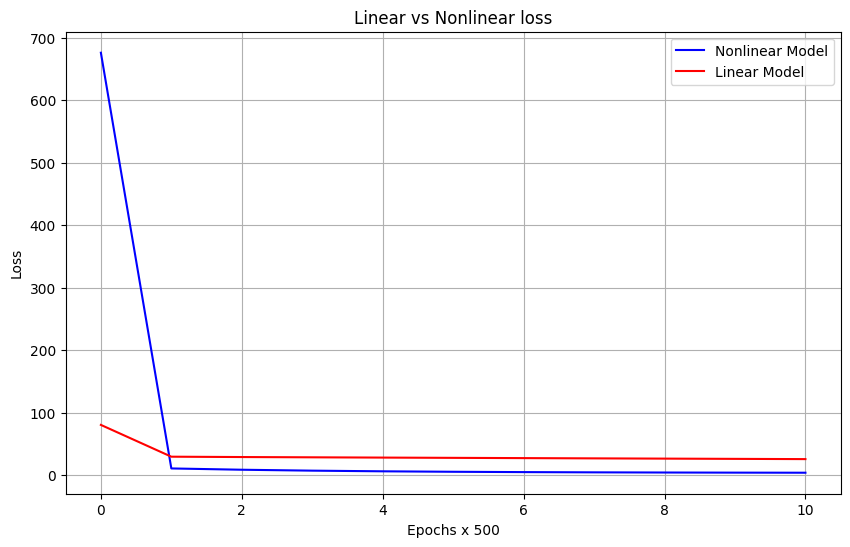

In [162]:
# Comparison with linear model
w2 = 1
w1 = 1
b = 0
nonLinLoss = training_loop_2nd_order(n_epochs=5000,params=torch.tensor([w2,w1,b]),lr=0.0001,loss_fn=loss_fn,t_c=t_c,t_u=t_un)
w1 = 1
b = 0
linLoss = training_loop_1st_order(n_epochs=5000,params=torch.tensor([w1,b]),lr=0.0001,loss_fn=loss_fn,t_c=t_c,t_u=t_un)
plt.plot(range(0, 11), nonLinLoss, color='blue') 
plt.plot(range(0, 11), linLoss, color='red') 
plt.rcParams["figure.figsize"] = (10,6) 
plt.grid() 
plt.xlabel('Epochs x 500') 
plt.ylabel('Loss') 
plt.title('Linear vs Nonlinear loss') 
plt.legend(['Nonlinear Model','Linear Model'])

In [ ]:
# The nonlinear model converges to a smaller loss value, making it the superior model.

In [ ]:
##_________________________________________##
## Problem 2
##_________________________________________##

In [202]:
# Input variables, standized and normalized sets
hd = pd.read_csv('Housing.csv')
x = hd[['area', 'bedrooms', 'bathrooms', 'stories', 'parking']]
xn = np.array(x*0.01)
print(xn[0:5])
y = hd[['price']]
yn = np.array(y*.000001)
print(yn[0:5])
x_train, x_test, y_train, y_test = train_test_split(xn, yn, test_size = 0.2)
x_train = torch.from_numpy(x_train)
x_train = x_train.unsqueeze(1)
x_test = torch.from_numpy(x_test)
x_test = x_test.unsqueeze(1)
y_train = torch.from_numpy(y_train)
y_train = y_train.unsqueeze(1)
y_test = torch.from_numpy(y_test)
y_test = y_test.unsqueeze(1)
#print(y_test)
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train.float())
        loss_train = loss_fn(t_p_train, t_c_train.float())
        t_p_val = model(t_u_val.float()) 
        loss_val = loss_fn(t_p_val, t_c_val.float())
        #val_acc = torch.sum(t_p_val == t_c_val.float())
        #val_acc = val_acc/t_c_val.size(0)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")#,f"Validation Accuracy {val_acc.item():.4f}")
            #print(t_p_val)
            #print(t_c_val)

[[7.42e+01 4.00e-02 2.00e-02 3.00e-02 2.00e-02]
 [8.96e+01 4.00e-02 4.00e-02 4.00e-02 3.00e-02]
 [9.96e+01 3.00e-02 2.00e-02 2.00e-02 2.00e-02]
 [7.50e+01 4.00e-02 2.00e-02 2.00e-02 3.00e-02]
 [7.42e+01 4.00e-02 1.00e-02 2.00e-02 2.00e-02]]
[[13.3  ]
 [12.25 ]
 [12.25 ]
 [12.215]
 [11.41 ]]


In [60]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [203]:
linear_model = nn.Linear(5, 1) 
optimizer = optim.SGD(linear_model.parameters(), lr=0.0001)
linear_model
training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = x_train,
    t_u_val = x_test, 
    t_c_train = y_train,
    t_c_val = y_test)

Epoch 1, Training loss 201.0744, Validation loss 164.1078
Epoch 1000, Training loss 3.2903, Validation loss 3.2647
Epoch 2000, Training loss 3.2362, Validation loss 3.2297
Epoch 3000, Training loss 3.1854, Validation loss 3.1973
Epoch 4000, Training loss 3.1375, Validation loss 3.1671
Epoch 5000, Training loss 3.0926, Validation loss 3.1392


In [204]:
linear_model = nn.Linear(5, 1) 
optimizer = optim.SGD(linear_model.parameters(), lr=0.001)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = x_train,
    t_u_val = x_test, 
    t_c_train = y_train,
    t_c_val = y_test)

Epoch 1, Training loss 12.0808, Validation loss 13.6972
Epoch 1000, Training loss nan, Validation loss nan
Epoch 2000, Training loss nan, Validation loss nan
Epoch 3000, Training loss nan, Validation loss nan
Epoch 4000, Training loss nan, Validation loss nan
Epoch 5000, Training loss nan, Validation loss nan


In [205]:
linear_model = nn.Linear(5, 1) 
optimizer = optim.SGD(linear_model.parameters(), lr=0.01)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = x_train,
    t_u_val = x_test, 
    t_c_train = y_train,
    t_c_val = y_test)

Epoch 1, Training loss 11.2619, Validation loss 7.8242
Epoch 1000, Training loss nan, Validation loss nan
Epoch 2000, Training loss nan, Validation loss nan
Epoch 3000, Training loss nan, Validation loss nan
Epoch 4000, Training loss nan, Validation loss nan
Epoch 5000, Training loss nan, Validation loss nan


In [206]:
linear_model = nn.Linear(5, 1) 
optimizer = optim.SGD(linear_model.parameters(), lr=0.1)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = x_train,
    t_u_val = x_test, 
    t_c_train = y_train,
    t_c_val = y_test)

Epoch 1, Training loss 87.3155, Validation loss 85.3025
Epoch 1000, Training loss nan, Validation loss nan
Epoch 2000, Training loss nan, Validation loss nan
Epoch 3000, Training loss nan, Validation loss nan
Epoch 4000, Training loss nan, Validation loss nan
Epoch 5000, Training loss nan, Validation loss nan


In [ ]:
#A learning rate of 0.0001 was the most optimal for this model, as it was the only model not to grossly overfit the data

In [ ]:
##_________________________________________##
## Problem 3
##_________________________________________##

In [207]:
from collections import OrderedDict

def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train.float()) # <1>

        loss_train = loss_fn(t_p_train, t_c_train.float())
        t_p_val = model(t_u_val.float()) # <1>
        loss_val = loss_fn(t_p_val, t_c_val.float())
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 50 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(5, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 5))
]))

print(seq_model.parameters)

optimizer = optim.SGD(seq_model.parameters(), lr=0.01) 

training_loop(
    n_epochs = 200, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = x_train.float(),
    t_u_val = x_test.float(), 
    t_c_train = y_train.float(),
    t_c_val = y_test.float())

<bound method Module.parameters of Sequential(
  (hidden_linear): Linear(in_features=5, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=5, bias=True)
)>
Epoch 1, Training loss 30.4283, Validation loss 32.0274
Epoch 50, Training loss 4.0300, Validation loss 5.1518
Epoch 100, Training loss 3.2306, Validation loss 4.2566
Epoch 150, Training loss 3.2870, Validation loss 4.3116
Epoch 200, Training loss 3.2865, Validation loss 4.3130


In [ ]:
#This neural net was slight less effective than the best linear regression model, 
#however it did slightly overfit

In [209]:
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(5, 8)),
    ('hidden_activation', nn.Tanh()),
    ('hidden_linear2', nn.Linear(8, 8)),
    ('hidden_activation2', nn.Tanh()),
    ('output_linear', nn.Linear(8, 5))
]))

print(seq_model.parameters)

optimizer = optim.SGD(seq_model.parameters(), lr=0.01) 

training_loop(
    n_epochs = 200, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = x_train.float(),
    t_u_val = x_test.float(), 
    t_c_train = y_train.float(),
    t_c_val = y_test.float())

<bound method Module.parameters of Sequential(
  (hidden_linear): Linear(in_features=5, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (hidden_linear2): Linear(in_features=8, out_features=8, bias=True)
  (hidden_activation2): Tanh()
  (output_linear): Linear(in_features=8, out_features=5, bias=True)
)>
Epoch 1, Training loss 26.2507, Validation loss 27.8016
Epoch 50, Training loss 4.8800, Validation loss 6.0444
Epoch 100, Training loss 3.3449, Validation loss 4.3984
Epoch 150, Training loss 3.2821, Validation loss 4.3137
Epoch 200, Training loss 3.2621, Validation loss 4.2836


In [ ]:
# This model seems marginally more effective than the previous without running into apparent overfitting